In [1]:
from brian2 import *
from brian2tools import * 
import random as pyrandom
import numpy
from numpy.random import randn as randn 
from numpy.random import rand as rand
from scipy.signal import lfilter
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
#It begins! 
def make_sensory_circuit(): 
     # Populations 
    N_E = 1600                                   # Total number of excitatory neurons
    N_E1 = int(0.5 * N_E)                        # Size of excitatory population E1
    N_E2 = N_E1                                  # Size of excitatory population E2
    N_I = 400                                    # Size of inhibitory population I
    N_X = 1000                                   # Size of external population X
    N_X1 = int(0.5 * N_X)                        # Size of external population X1
    N_X2 = int(0.5 * N_X)                        # Size of external population X2

        # Connectivity - local recurrent connections
    p = 0.2                                      # Connection probability for (EE, EI, IE, II)
    w_p = 1.3                                    # Relative synaptic strength of connections within populations E1 and E2
    w_m = 2.0 - w_p                              # Relative synaptic strength of connections across populations E1 and E2
    gEE = 0.7589 * nS  #Brian2 loves units!                           # Weight of excitatory to excitatory synapses
    gEI = 1.5179 * nS                            # Weight of excitatory to inhibitory synapses
    gIE = 12.6491 * nS                           # Weight of inhibitory to excitatory synapses
    gII = gIE                                    # Weight of inhibitory to inhibitory synapses
    dE = (0.5 * ms, 1.5 * ms)                    # Range of uniformly distributed transmission delays of excitatory connections
    dI = (0.1 * ms, 0.9 * ms)                    # Range of uniformly distributed transmission delays of inhibitory connections

        # Connectivity - external connections
    p_x = 0.32                                   # Connection probability for external connections
    alpha_x = 0.0
    gextE = 1.7076 * nS                          # Weight of external to excitatory synapses
    gextI = 1.7076 * nS                          # Weight of external to inhibitory synapses
    dXE = (0.5 * ms, 1.5 * ms)                   # Range of uniformly distributed transmission delays of external connections

        # Neuron model
    CmE = 0.25 * nF                              # Membrane capacitance of excitatory neurons
    CmI = 0.25 * nF                              # Membrane capacitance of inhibitory neurons
    gLeakE = 16.7 * nS                           # Leak conductance of excitatory neurons
    gLeakI = 16.7 * nS                           # Leak conductance of inhibitory neurons
    Vl = -70.0 * mV                              # Resting potential
    Vt = -50.0 * mV                              # Spiking threshold
    Vr = -60.0 * mV                              # Reset potential
    tau_refE = 2.0 * ms                          # Absolute refractory period of excitatory neurons
    tau_refI = 1.0 * ms                          # Absolute refractory period of inhibitory neurons
    nu_ext = 12.5 * Hz                           # Firing rate of external Poisson neurons 

        # Synapse model
    VrevE = 0 * mV                               # Reversal potential of excitatory synapses
    VrevI = -80 * mV                             # Reversal potential of inhibitory synapses
    tau_decay = 5.0 * ms                         # Decay constants of AMPA-type and GABA-type conductances
    tau_rise = 1.0 * ms                          # Rise constant of AMPA- and GABA-type conductances
        # Neuron equations
        #Is it the refractoriness parameter that's screwing up the code? (no, but that is important). 
        #It's probably namespace, but that throws out more errors. 
    eqs = '''
        dV/dt = (-gea*(V-VrevE) - gi*(V-VrevI) - (V-Vl)) * (1.0/tau) + I/Cm: volt (unless refractory)
        dgea/dt = (ye-gea)*(1.0/tau_decay)        : 1
        dye/dt = -ye*(1.0/tau_rise)               : 1     
        dgi/dt = (yi-gi)*(1.0/tau_decay)          : 1
        dyi/dt = -yi*(1.0/tau_rise)               : 1     
        I : amp
        tau : second
        Cm : farad 
        ''' 
    #You cannot name a variable xi because that's what all the noise is named. 
    sensoryE = NeuronGroup(N_E, model=eqs, method='euler', namespace=locals(), threshold='V>Vt', reset='V=Vr', refractory=tau_refE) #Excitatory neurons. 
    sensoryI = NeuronGroup(N_I, model=eqs, method='euler', namespace=locals(), threshold='V>Vt', reset='V=Vr', refractory=tau_refI) #Inhibitory neurons 
    sensoryE.tau = CmE / gLeakE
    sensoryE.Cm = CmE 
    sensoryI.tau = CmI / gLeakI
    sensoryI.Cm = CmI
    sensoryE.I = 0.0
    sensoryI.I = 0.0
    sensoryE1 = sensoryE[:N_E1]
    sensoryE2 = sensoryE[N_E2:] #How to make sub-populations of neurons 
    external = PoissonGroup(N_X, rates = nu_ext)
    external1=external[:N_X1]
    external2=external[N_X2:]
    #Synapses here 
    #E1 to E1 synapses 
    C_SE1_SE1 = Synapses(sensoryE1, sensoryE1, 'w: 1', on_pre='ye+=w', namespace=locals()) #Okay, lots of wrangling to be done
    C_SE1_SE1.connect(p=0.2) #I think you need to separate these guys into different groups as the weights are different. 
    C_SE1_SE1.w='w_p*gEE/gLeakE*clip(1.0 + 0.5 * randn(), 0.0, inf)' #Fix from brian2 website. 
    C_SE1_SE1.delay='randn()*1.5*ms'
    #E2 to E2 synapes 
    C_SE2_SE2 = Synapses(sensoryE2, sensoryE2, 'w: 1', on_pre='ye+=w', namespace=locals()) #No, it's not a dimensionality error either.
    C_SE2_SE2.connect(p=0.2)  
    C_SE2_SE2.w='w_p*gEE/gLeakE*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SE2_SE2.delay='randn()*1.5*ms'
    #E1 to E2 synapses 
    C_SE1_SE2 = Synapses(sensoryE1, sensoryE2, 'w: 1', on_pre='ye+=w', namespace=locals()) 
    C_SE1_SE2.connect(p=0.2)  
    C_SE1_SE2.w='w_m*gEE/gLeakE*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SE1_SE2.delay='randn()*1.5*ms'
    #E2 to E1 synapses 
    C_SE2_SE1 = Synapses(sensoryE2, sensoryE1, 'w: 1', on_pre='ye+=w', namespace=locals()) 
    C_SE2_SE1.connect(p=0.2)  
    C_SE2_SE1.w='w_m*gEE/gLeakE*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SE2_SE1.delay='randn()*1.5*ms'
    #E to I synapses 
    C_SE_SI=Synapses(sensoryE, sensoryI, 'w: 1', on_pre='ye+=w', namespace=locals()) 
    C_SE_SI.connect(p=0.2)
    C_SE_SI.w='gEI/gLeakI*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SE_SI.delay='randn()*1.5*ms'
    #I to E synapses 
    C_SI_SE=Synapses(sensoryI, sensoryE, 'w: 1', on_pre='yi+=w', namespace=locals()) 
    C_SI_SE.connect(p=0.2)
    C_SI_SE.w='gIE/gLeakE*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SI_SE.delay='randn()*0.9*ms'
    #I to I synapses 
    C_SI_SI=Synapses(sensoryI, sensoryI, 'w: 1', on_pre='yi+=w', namespace=locals()) 
    C_SI_SI.connect(p=0.2)
    C_SI_SI.w='gII/gLeakI*clip(1.0 + 0.5* randn(), 0.0, inf)' 
    C_SI_SI.delay='randn()*0.9*ms'
    #X1 to E1 synapses 
    C_SX1_SE1=Synapses(external1, sensoryE1, 'w: 1', on_pre='ye+=w', namespace=locals()) 
    C_SX1_SE1.connect(p=p_x*(1+alpha_x))
    C_SX1_SE1.w='gextE/gLeakE*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SX1_SE1.delay='randn()*1.5*ms'
    #X2 to E2 synapses 
    C_SX2_SE2=Synapses(external2, sensoryE2, 'w: 1', on_pre='ye+=w', namespace=locals()) 
    C_SX2_SE2.connect(p=p_x*(1+alpha_x))
    C_SX2_SE2.w='gextE/gLeakE*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SX2_SE2.delay='randn()*1.5*ms'
    #X1 to E2 synapses 
    C_SX1_SE2=Synapses(external1, sensoryE2, 'w: 1', on_pre='ye+=w', namespace=locals()) 
    C_SX1_SE2.connect(p=p_x*(1-alpha_x))
    C_SX1_SE2.w='gextE/gLeakE*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SX1_SE2.delay='randn()*1.5*ms'
    #X2 to E1 synapses 
    C_SX2_SE1=Synapses(external2, sensoryE1, 'w: 1', on_pre='ye+=w', namespace=locals()) 
    C_SX2_SE1.connect(p=p_x*(1-alpha_x))
    C_SX2_SE1.w='gextE/gLeakE*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SX2_SE1.delay='randn()*1.5*ms'
    #X to I synapses 
    C_SX_SI=Synapses(external, sensoryI, 'w: 1', on_pre='ye+=w', namespace=locals()) 
    C_SX_SI.connect(p=p_x)
    C_SX_SI.w='gextI/gLeakI*clip(1.0 + 0.5 * randn(), 0.0, inf)' 
    C_SX_SI.delay='randn()*1.5*ms'
    # Return the sensory circuit
    groups = {'SE': sensoryE, 'SI': sensoryI, 'SX': external}
    subgroups = {'SE1': sensoryE1, 'SE2': sensoryE2}
    connections = {'C_SX1_SE1': C_SX1_SE1, 'C_SX1_SE2': C_SX1_SE2, 'C_SX2_SE1': C_SX2_SE1, 'C_SX2_SE2': C_SX2_SE2,'C_SX_SI': C_SX_SI, 
                       'C_SE1_SE1': C_SE1_SE1, 'C_SE1_SE2': C_SE1_SE2,'C_SE2_SE1': C_SE2_SE1,'C_SE2_SE2': C_SE2_SE2, 'C_SE_SI': C_SE_SI, 'C_SI_SE': C_SI_SE, 'C_SI_SI': C_SI_SI}

    return groups, connections, subgroups


In [3]:
#Does it matter if all the variables have the same name between functions? 
def make_integration_circuit(): #Layer 2, with some biological plausibility. 
    
    '''
    Creates the spiking network described in Wang 2002.
    
    returns:
        groups, connections, update_nmda, subgroups
        
    groups, connections, and update_nmda have to be added to the "Network" in order to run the simulation.
    subgroups is used for establishing connections between the sensory and integration circuit; do not add subgroups to the "Network"

    ''' 
    # Populations
    f_E = 0.15                                   # Fraction of stimulus-selective excitatory neurons
    N = 2000                                     # Total number of neurons
    f_inh = 0.2                                  # Fraction of inhibitory neurons
    NE = int(N * (1.0 - f_inh))                  # Number of excitatory neurons (1600)
    NI = int(N * f_inh)                          # Number of inhibitory neurons (400)
    N_D1 = int(f_E * NE)                         # Size of excitatory population D1
    N_D2 = N_D1                                  # Size of excitatory population D2
    N_DN = int((1.0 - 2.0 * f_E) * NE)           # Size of excitatory population DN

    # Connectivity - local recurrent connections
    w_p = 1.6                                    # Relative recurrent synaptic strength within populations D1 and D2
    w_m = 1.0 - f_E * (w_p - 1.0) / (1.0 - f_E) # Relative recurrent synaptic strength of connections across populations D1 and D2 and from DN to D1 and D2
    gEE_AMPA = 0.05 * nS                    # Weight of AMPA synapses between excitatory neurons
    gEE_NMDA = 0.165 * nS                        # Weight of NMDA synapses between excitatory neurons
    gEI_AMPA = 0.04 * nS                         # Weight of excitatory to inhibitory synapses (AMPA)
    gEI_NMDA = 0.13 * nS                         # Weight of excitatory to inhibitory synapses (NMDA)
    gIE_GABA = 1.3 * nS                          # Weight of inhibitory to excitatory synapses
    gII_GABA = 1.0 * nS                          # Weight of inhibitory to inhibitory synapses
    d = 0.5 * ms                                 # Transmission delay of recurrent excitatory and inhibitory connections
                                                
    # Connectivity - external connections
    gextE = 2.1 * nS                             # Weight of external input to excitatory neurons
    gextI = 1.62 * nS                            # Weight of external input to inhibitory neurons

    # Neuron model
    CmE = 0.5 * nF                               # Membrane capacitance of excitatory neurons
    CmI = 0.2 * nF                               # Membrane capacitance of inhibitory neurons
    gLeakE = 25.0 * nS                           # Leak conductance of excitatory neurons
    gLeakI = 20.0 * nS                           # Leak conductance of inhibitory neurons
    Vl = -70.0 * mV                              # Resting potential
    Vt = -50.0 * mV                              # Spiking threshold
    Vr = -55.0 * mV                              # Reset potential
    tau_refE = 2.0 * ms                          # Absolute refractory period of excitatory neurons
    tau_refI = 1.0 * ms                          # Absolute refractory period of inhibitory neurons
    
    # Synapse model
    VrevE = 0 * mV                               # Reversal potential of excitatory synapses
    VrevI = -70 * mV                             # Reversal potential of inhibitory synapses
    tau_AMPA = 2.0 * ms                          # Decay constant of AMPA-type conductances
    tau_GABA = 5.0 * ms                          # Decay constant of GABA-type conductances
    tau_NMDA_decay = 100.0 * ms                  # Decay constant of NMDA-type conductances
    tau_NMDA_rise = 2.0 * ms                     # Rise constant of NMDA-type conductances
    alpha_NMDA = 0.5 * kHz                       # Saturation constant of NMDA-type conductances
    
    # Inputs
    nu_ext_1 = 2392 * Hz             # Firing rate of external Poisson input to neurons in population D1
    nu_ext_2 = 2392 * Hz               # Firing rate of external Poisson input to neurons in population D2
    nu_ext = 2400 * Hz                 # Firing rate of external Poisson input to neurons in population Dn and I
    # External inputs
    extinputE1 = PoissonGroup(N_D1, rates = nu_ext_1) 
    extinputE2 = PoissonGroup(N_D2, rates = nu_ext_2)
    extinputE3 = PoissonGroup(N_DN, rates = nu_ext)
    extinputI = PoissonGroup(NI, rates = nu_ext)
    eqsE = '''
    dV/dt = (-gea*(V-VrevE) - gen*(V-VrevE)/(1.0+exp(-V/mV*0.062)/3.57) - gi*(V-VrevI) - (V-Vl)) / (tau): volt (unless refractory)
    dgea/dt = -gea/(tau_AMPA) : 1
    dgi/dt = -gi/(tau_GABA) : 1
    dspre/dt = -spre/(tau_NMDA_decay)+alpha_NMDA*xpre*(1-spre) : 1
    dxpre/dt= -xpre/(tau_NMDA_rise) : 1
    gen : 1
    tau : second
        '''
    eqsI = '''
        dV/dt = (-gea*(V-VrevE) - gen*(V-VrevE)/(1.0+exp(-V/mV*0.062)/3.57) - gi*(V-VrevI) - (V-Vl)) / (tau): volt (unless refractory)
        dgea/dt = -gea/(tau_AMPA) : 1
        dgi/dt = -gi/(tau_GABA) : 1
        gen : 1
        tau : second
        '''

    # Set up the integration circuit
    decisionE = NeuronGroup(NE, model=eqsE, method='euler', namespace=locals(), threshold='V>Vt', reset='V=Vr', refractory=tau_refE)
    decisionI = NeuronGroup(NI, model=eqsI, method='euler', namespace=locals(), threshold='V>Vt', reset='V=Vr', refractory=tau_refI)
    decisionE.tau = CmE / gLeakE
    decisionI.tau = CmI / gLeakI      
    decisionE1 = decisionE[:N_D1]
    decisionE2 = decisionE[N_D1:N_D1+N_D2]
    decisionE3 = decisionE[N_D1+N_D2:]
    #DE1 to DE1
    C_DE1_DE1_AMPA = Synapses(decisionE1, decisionE1, 'w: 1', on_pre='gea+=w', namespace=locals())  #Pay attention to units. 
    C_DE1_DE1_AMPA.connect() #Connect_full and connect_one_to_one are not the same thing! 
    C_DE1_DE1_AMPA.w=w_p * gEE_AMPA / gLeakE
    C_DE1_DE1_AMPA.delay=d
    #DE2 to DE2
    C_DE2_DE2_AMPA = Synapses(decisionE2, decisionE2, 'w: 1', on_pre='gea+=w', namespace=locals())   
    C_DE2_DE2_AMPA.connect()
    C_DE2_DE2_AMPA.w=w_p * gEE_AMPA / gLeakE
    C_DE2_DE2_AMPA.delay=d
    #DE1 to DE2
    C_DE1_DE2_AMPA = Synapses(decisionE1, decisionE2, 'w: 1', on_pre='gea+=w', namespace=locals())   
    C_DE1_DE2_AMPA.connect()
    C_DE1_DE2_AMPA.w=w_m * gEE_AMPA / gLeakE
    C_DE1_DE2_AMPA.delay=d
    #DE2 to DE1 
    C_DE2_DE1_AMPA = Synapses(decisionE2, decisionE1, 'w: 1', on_pre='gea+=w', namespace=locals())   
    C_DE2_DE1_AMPA.connect()
    C_DE2_DE1_AMPA.w=w_m * gEE_AMPA / gLeakE
    C_DE2_DE1_AMPA.delay=d
    #DE3 to DE1  
    C_DE3_DE1_AMPA = Synapses(decisionE3, decisionE1, 'w: 1', on_pre='gea+=w', namespace=locals())   
    C_DE3_DE1_AMPA.connect()
    C_DE3_DE1_AMPA.w=w_m * gEE_AMPA / gLeakE
    C_DE3_DE1_AMPA.delay=d
    #DE3 to DE2
    C_DE3_DE2_AMPA = Synapses(decisionE3, decisionE2, 'w: 1', on_pre='gea+=w', namespace=locals())   
    C_DE3_DE2_AMPA.connect()
    C_DE3_DE2_AMPA.w=w_m * gEE_AMPA / gLeakE
    C_DE3_DE2_AMPA.delay=d
    #DE1 to DE3
    C_DE1_DE3_AMPA = Synapses(decisionE1, decisionE3, 'w: 1', on_pre='gea+=w', namespace=locals())   
    C_DE1_DE3_AMPA.connect()
    C_DE1_DE3_AMPA.w=gEE_AMPA / gLeakE
    C_DE1_DE3_AMPA.delay=d
    #DE2 to DE3
    C_DE2_DE3_AMPA = Synapses(decisionE2, decisionE3, 'w: 1', on_pre='gea+=w', namespace=locals())   
    C_DE2_DE3_AMPA.connect()
    C_DE2_DE3_AMPA.w=gEE_AMPA / gLeakE
    C_DE2_DE3_AMPA.delay=d
    #DE3 to DE3
    C_DE3_DE3_AMPA = Synapses(decisionE3, decisionE3, 'w: 1', on_pre='gea+=w', namespace=locals())   
    C_DE3_DE3_AMPA.connect()
    C_DE3_DE3_AMPA.w= gEE_AMPA / gLeakE
    C_DE3_DE3_AMPA.delay=d
    #DE to DI
    C_DE_DI_AMPA = Synapses(decisionE, decisionI, 'w: 1', on_pre='gea+=w', namespace=locals())   
    C_DE_DI_AMPA.connect()
    #C_DE_DI_AMPA.connect(j='i')
    C_DE_DI_AMPA.w= gEI_AMPA / gLeakI
    C_DE_DI_AMPA.delay=d
    #NMDA
    selfnmda = Synapses(decisionE, decisionE, 'w : 1', on_pre='xpre+=w', namespace=locals())
    selfnmda.connect(j='i')
    selfnmda.w=1.0
    selfnmda.delay=d
    #Marcel Steinberg's fix for the NMDA synapses 
    @network_operation(when='start') #NMDA calculations
    def update_nmda():
        sE1 = sum(decisionE1.spre[:])
        sE2 = sum(decisionE2.spre[:])
        sE3 = sum(decisionE3.spre[:])
        decisionE1.gen[:] = gEE_NMDA / gLeakE * (w_p*sE1 + w_m*sE2 + w_m*sE3)
        decisionE2.gen[:] = gEE_NMDA / gLeakE * (w_m*sE1 + w_p*sE2 + w_m*sE3)
        decisionE3.gen[:] = gEE_NMDA / gLeakE * (sE1 + sE2 + sE3)
        decisionI.gen[:] = gEI_NMDA / gLeakI * (sE1 + sE2 + sE3)
    #E1_nmda = asarray(decisionE1.spre)
    #E2_nmda = asarray(decisionE2.spre)
    #E3_nmda = asarray(decisionE3.spre)         
    #E1_gen = asarray(decisionE1.gen) 
    #E2_gen = asarray(decisionE2.gen)
    #E3_gen = asarray(decisionE3.gen)
    #I_gen = asarray(decisionI.gen)
    #@network_operation(when='start') #NMDA calculations. Is this what isn't working? Yes. 
   # def update_nmda():
        #sE1 = sum(E1_nmda)
        #sE2 = sum(E2_nmda)
        #sE3 = sum(E3_nmda)
        #E1_gen[:] = gEE_NMDA / gLeakE * (w_p*sE1 + w_m*sE2 + w_m*sE3)
        #E2_gen[:] = gEE_NMDA / gLeakE * (w_m*sE1 + w_p*sE2 + w_m*sE3)
        #E3_gen[:] = gEE_NMDA / gLeakE * (sE1 + sE2 + sE3)
        #I_gen[:] = gEI_NMDA / gLeakI * (sE1 + sE2 + sE3)  
    
    #DI to DE
    C_DI_DE = Synapses(decisionI, decisionE, 'w: 1', on_pre='gi+=w', namespace=locals())  
    C_DI_DE.connect()
    C_DI_DE.w=gIE_GABA / gLeakE
    C_DI_DE.delay=d
    #DI to DI
    C_DI_DI = Synapses(decisionI, decisionI, 'w: 1', on_pre='gi+=w', namespace=locals()) 
    C_DI_DI.connect()
    C_DI_DI.w=gII_GABA / gLeakI
    C_DI_DI.delay=d
    #X1 to E1
    C_X1_E1=Synapses(extinputE1, decisionE1, 'w : 1', on_pre='gea+=w', namespace=locals())
    C_X1_E1.connect(j='i')
    C_X1_E1.w=gextE / gLeakE #BE CAREFUL! 
    C_X1_E1.delay=d
    #X2 to E2 
    C_X2_E2=Synapses(extinputE2, decisionE2, 'w : 1', on_pre='gea+=w', namespace=locals())
    C_X2_E2.connect(j='i')
    C_X2_E2.w=gextE / gLeakE
    C_X2_E2.delay=d
    #X3 to E3 
    C_X3_E3=Synapses(extinputE3, decisionE3,  'w : 1', on_pre='gea+=w', namespace=locals())
    C_X3_E3.connect(j='i')
    C_X3_E3.w=gextE / gLeakE
    C_X3_E3.delay=d
    #XI to I
    C_XI_I=Synapses(extinputI, decisionI, 'w : 1', on_pre='gea+=w', namespace=locals())
    C_XI_I.connect(j='i')
    C_XI_I.w=gextI / gLeakI
    C_XI_I.delay=d
    groups = {'DE': decisionE, 'DI': decisionI, 'DX1': extinputE1, 'DX2': extinputE2, 'DX3': extinputE3, 'DXI': extinputI}
    subgroups = {'DE1': decisionE1, 'DE2': decisionE2, 'DE3': decisionE3}  
    connections = {'selfnmda': selfnmda,
                   'extconnE1': C_X1_E1, 'extconnE2': C_X2_E2, 'extconnE3': C_X3_E3, 'extconnI': C_XI_I, 
                   'C_DE1_DE1_AMPA': C_DE1_DE1_AMPA, 'C_DE2_DE2_AMPA': C_DE2_DE2_AMPA, 'C_DE1_DE2_AMPA': C_DE1_DE2_AMPA,'C_DE2_DE1_AMPA': C_DE2_DE1_AMPA, 'C_DE3_DE1_AMPA': C_DE3_DE1_AMPA, 'C_DE3_DE2_AMPA': C_DE3_DE2_AMPA, 'C_DE1_DE3_AMPA': C_DE1_DE3_AMPA, 'C_DE3_DE3_AMPA': C_DE3_DE3_AMPA, 'C_DE2_DE3_AMPA': C_DE2_DE3_AMPA, 'C_DE_DI_AMPA': C_DE_DI_AMPA, 'C_DI_DE': C_DI_DE, 'C_DI_DI': C_DI_DI }
    return groups, connections, update_nmda, subgroups 

In [4]:
#Simulation cell
def get_OU_stim(n, tau):
# UO process in discrete time => AR(1) process
      
    a = numpy.exp(-(1.0 / tau))
    i = lfilter(numpy.ones(1),[1.0, -a], numpy.sqrt(1-a*a)*randn(n))   
         
    return i



if __name__ == '__main__': #Okay, don't just blindly delete this part. 
    #The initiallization line was removed from brian2. 
    
    connect_seed = 1284                          # seed for random number generators (set before establishing network connectivity)
    stim_seed = 123                              # seed for random number generators (set before generating common part of stimulus)
    init_seed = 8190                             # seed for random number generators (set before generating private part of stimulus)

    #Reseeding 
    #connect_seed = pyrandom.randint(1, 100000)                          
    #stim_seed = pyrandom.randint(1, 100000)                               
    #init_seed = pyrandom.randint(1, 100000)   
    # Timing 
    stim_on = 500.0 * ms                         # stimulus onset
    stim_off = 2500.0 * ms                       # stimulus offset   
    stim_duration = stim_off - stim_on           # duration of stimulus interval
    runtime = 3000.0 * ms                        # total simulation time
    # Set the seed of the random number generator
    numpy.random.seed(connect_seed) 
    pyrandom.seed(connect_seed)

    # Integration circuit
    Dgroups, Dconnections, Dnetfunctions, Dsubgroups = make_integration_circuit() 

    # get populations from the integrations circuit
    decisionE = Dgroups['DE']
    decisionI = Dgroups['DI']
    decisionE1 = Dsubgroups['DE1']
    decisionE2 = Dsubgroups['DE2']
    decisionE3 = Dsubgroups['DE3']

    # Sensory network  
    Sgroups, Sconnections, Ssubgroups = make_sensory_circuit()

    # get sensory populations
    sensoryE = Sgroups['SE']
    sensoryI = Sgroups['SI']
    sensoryE1 = Ssubgroups['SE1']
    sensoryE2 = Ssubgroups['SE2']

    # Feed-forward connections from the sensory to the integration circuit

    wSD = 0.0036                                 # Synaptic weight of feed-forward connections from the corresponding stimulus-encoding population 
                                                 # from the sensory circuit (E1 -> D1, E2 -> D2); 
                                                 # synaptic weight (0.09 nS) is given in multiples of the leak conductance of the excitatory neurons in the integration circuit  

    C_SE1_DE1=Synapses(sensoryE1, decisionE1, 'w: 1', on_pre='gea+=w')
    C_SE1_DE1.connect(p=0.2)
    C_SE1_DE1.w=wSD 
    C_SE1_DE1.delay=1.0*ms 
    C_SE2_DE2=Synapses(sensoryE2, decisionE2, 'w: 1', on_pre='gea+=w')
    C_SE2_DE2.connect(p=0.2)
    C_SE2_DE2.w=wSD 
    C_SE2_DE2.delay=1.0*ms 
    # Top-down feedback connections from the integration circuit to the sensory circuit

    b_FB = 0.0                                   # Feedback strength
    wDS = 0.004 * b_FB                           # Synaptic weight of feedback connections from the integration circuit to the sensory circuit (D1 -> E1, D2 -> E2);
                                                 # synaptic weight (0.0668 nS) is given in multiples of the leak conductance of the excitatory neurons in the sensory circuit  


    C_DE1_SE1=Synapses(decisionE1, sensoryE1, 'w: 1', on_pre='ye+=w')
    C_DE1_SE1.connect(p=0.2)
    C_DE1_SE1.w=wDS 
    C_DE1_SE1.delay=1.0*ms 
    C_DE2_SE2=Synapses(decisionE2, sensoryE2, 'w: 1', on_pre='ye+=w')
    C_DE2_SE2.connect(p=0.2)
    C_DE2_SE2.w=wDS 
    C_DE2_SE2.delay=1.0*ms 


    # Stimulus parameters    
    I0 = 0.08 * nA                               # Mean input current for zero-coherence stimulus 
    c = 0.0                                      # Stimulus coherence (between 0 and 1) 
    mu_E1 = +0.25                                # Average additional input current to E1 at highest coherence (c = 1)
    mu_E2 = -0.25                                # Average additional input current to E2 at highest coherence (c = 1)    
    sigma = 1.0                                  # Amplitude of temporal modulations of the stimulus
    sigma_stim = 0.212 * sigma                   # S.d. of modulations of stimulus inputs
    sigma_ind = 0.212 * sigma                    # S.d. of modulations in individual inputs
    tau_stim = 20.0 * ms                         # Correlation time constant of Ornstein-Uhlenbeck process

    # Generate stimulus
    # set seed of random number generator (in order to generate a specific stimulus each time)
    numpy.random.seed(stim_seed)    
    pyrandom.seed(stim_seed)

    # "common part" of the stimulus
    z1 = get_OU_stim(int(stim_duration/ms), tau_stim/ms)
    z1 = numpy.tile(z1,(len(sensoryE1),1))
    z2 = get_OU_stim(int(stim_duration/ms), tau_stim/ms)
    z2 = numpy.tile(z2,(len(sensoryE2),1))

    # set seed of random number generator (in order to generate a specific stimulus each time)
    numpy.random.seed(init_seed)    
    pyrandom.seed(init_seed)

    # "private part" - part of the stimulus for each neuron, different in each trial               
    zk1 = get_OU_stim(int(stim_duration/ms * len(sensoryE1)), tau_stim/ms)  
    zk1 = numpy.asarray(zk1).reshape(len(sensoryE1), int(stim_duration/ms))
    zk2 = get_OU_stim(int(stim_duration/ms * len(sensoryE2)), tau_stim/ms)  
    zk2 = numpy.asarray(zk2).reshape(len(sensoryE2), int(stim_duration/ms))

    # stimulus (time series with dt = 1ms)
    # most general case: different input to each neuron in each time step 
    i1 = I0 * (1 + c * mu_E1 + sigma_stim * z1 + sigma_ind * zk1)     
    i2 = I0 * (1 + c * mu_E2 + sigma_stim * z2 + sigma_ind * zk2)     
    ii = numpy.zeros((len(sensoryI),int(stim_duration/ms)))     # no current input to inh population

    # Stimulus-related external current input     
    defaultclock.dt=0.1*ms    
    @network_operation(defaultclock)
    def update_input():  
        if defaultclock.t >= stim_on and defaultclock.t < stim_off: #Does this fix it?           
            sensoryE1.I = i1[:,int((defaultclock.t - stim_on) / (1 * ms))] #* amp
            sensoryE2.I = i2[:,int((defaultclock.t - stim_on) / (1 * ms))] #* amp
            sensoryI.I = ii[:,int((defaultclock.t - stim_on) / (1 * ms))] #* amp
        else:
            sensoryE1.I = 0 * nA
            sensoryE2.I = 0 * nA
            sensoryI.I = 0 * nA
    # --- set seed of random number generator to a different value in each run
    np_seed = int(1587.47)
    numpy.random.seed(np_seed)
    py_seed = int(4736.28) 
    pyrandom.seed(py_seed)

    # ---- set initial conditions (random)
    #decisionE.gen = decisionE.gen * (1 + 0.2 * rand(decisionE.__len__())) #This is a different initial condition. 
    #decisionI.gen = decisionI.gen * (1 + 0.2 * rand(decisionI.__len__()))
    #It is not an initial condition problem. 
    decisionE.gen='1+0.2*rand()' #Syntax stuff 
    decisionI.gen='1+0.2*rand()'
    #decisionE.V = decisionE.V + rand(decisionE.__len__()) * 2 * mV
    #decisionI.V = decisionI.V + rand(decisionI.__len__()) * 2 * mV #Removes the 'all neurons spike at t=0' problem
    decisionE.V='-52*mV + rand()*2*mV'
    decisionI.V='-52*mV + rand()*2*mV'

    # ---- set initial conditions (random)
    #sensoryE.V = -50.0 * mV - 2 * mV + rand(sensoryE.__len__()) * 2 * mV
    #sensoryI.V = -50.0 * mV - 2 * mV + rand(sensoryI.__len__()) * 2 * mV
    sensoryE.V ='-52*mV+rand()*2*mV'
    sensoryI.V ='-52*mV+rand()*2*mV'
    #sensoryE.gea = 0.05 * (1 + rand(sensoryE.__len__()) * 0.2)
    #sensoryI.gea = 0.05 * (1 + rand(sensoryI.__len__()) * 0.2)
    sensoryE.gea='0.05*(1+0.2*rand())'
    sensoryI.gea='0.05*(1+0.2*rand())'

    # record spikes of excitatory neurons
    S_DE1 = SpikeMonitor(decisionE1, record=True)
    S_DE2 = SpikeMonitor(decisionE2, record=True)
    S_SE1 = SpikeMonitor(sensoryE1, record=True)
    S_SE2 = SpikeMonitor(sensoryE2, record=True)

    # record instantaneous populations activity
    R_DE1 = PopulationRateMonitor(decisionE1) 
    R_DE2 = PopulationRateMonitor(decisionE2)
    R_SE1 = PopulationRateMonitor(sensoryE1)
    R_SE2 = PopulationRateMonitor(sensoryE2)
    
    #sanity checks? 
    #NMDA_DE1=StateMonitor(decisionE1, 'spre', record=True)
    #NMDA_DE2=StateMonitor(decisionE2, 'spre', record=True)
    # construct network       
    net = Network(Dgroups.values(), Sgroups.values(), Dconnections.values(), Sconnections.values(), 
                  Dnetfunctions, update_input, C_SE1_DE1, C_SE2_DE2, C_DE1_SE1, C_DE2_SE2,
                  S_DE1, S_DE2, S_SE1, S_SE2, R_DE1, R_DE2, R_SE1, R_SE2)
    net.run(runtime) 
    

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


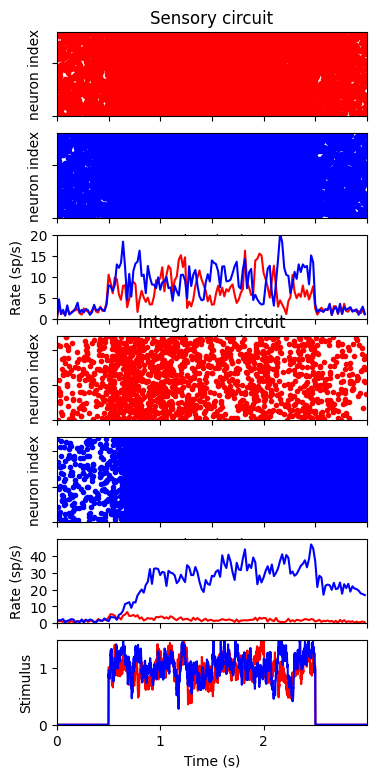

In [9]:
# Sensory circuit
bins=int(20*ms/defaultclock.dt)
binned_t=R_DE1.t[::bins]
fig, axs = subplots(7,1, figsize=(4,9)) 
fig.add_axes(axs[0])
plot_raster(S_SE1.i, S_SE1.t,color=(1,0,0))
xlim(0,runtime/ms)   
ylim(0,len(sensoryE1))
axs[0].set_title('Sensory circuit')
fig.add_axes(axs[1])
plot_raster(S_SE2.i, S_SE2.t,color=(0,0,1))
xlim(0,runtime/ms)   
ylim(0,len(sensoryE2))
fig.add_axes(axs[2])
plot_rate(binned_t, np.reshape(R_SE1.rate, (-1, bins)).mean(axis=1), color=(1,0,0)) #Less annoying 
plot_rate(binned_t, np.reshape(R_SE2.rate, (-1, bins)).mean(axis=1), color=(0,0,1))
yticks(range(0,30,5)) 
xlim(0,runtime/ms)   
ylim(0,20)
ylabel("Rate (sp/s)")
fig.add_axes(axs[3])
plot_raster(S_DE1.i, S_DE1.t,color=(1,0,0))
xlim(0,runtime/ms)   
ylim(0,len(decisionE1))
axs[3].set_title('Integration circuit')
fig.add_axes(axs[4])
plot_raster(S_DE2.i, S_DE2.t,color=(0,0,1))
xlim(0,runtime/ms)   
ylim(0,len(decisionE2))
fig.add_axes(axs[5])
plot_rate(binned_t, np.reshape(R_DE1.rate, (-1, bins)).mean(axis=1), color=(1,0,0)) 
plot_rate(binned_t, np.reshape(R_DE2.rate, (-1, bins)).mean(axis=1), color=(0,0,1)) 
yticks(range(0,50,10))
#yticks(range(0,30,5)) 
xlim(0,runtime/ms)   
ylim(0,50)
ylabel("Rate (sp/s)")
fig.add_axes(axs[6])
t = linspace(0., int(runtime/second), int(runtime/ms))
plot(t, numpy.r_[zeros(int(stim_on/ms)), mean(i1,0)/I0, zeros(int((runtime-stim_off)/ms))], color=(1,0,0))
plot(t, numpy.r_[zeros(int(stim_on/ms)), mean(i2,0)/I0, zeros(int((runtime-stim_off)/ms))], color=(0,0,1))
xticks(range(0,3))
yticks(range(0,2,1))
xlim(0,runtime/second)
ylim(0,1.5)
xlabel("Time (s)")
ylabel("Stimulus")
for i in [0,1,3,4]:
    axs[i].set_yticklabels([])
for i in range(0,6):
    axs[i].set_xticklabels([])   
show()

<AxesSubplot: xlabel='source neuron index', ylabel='target neuron index'>

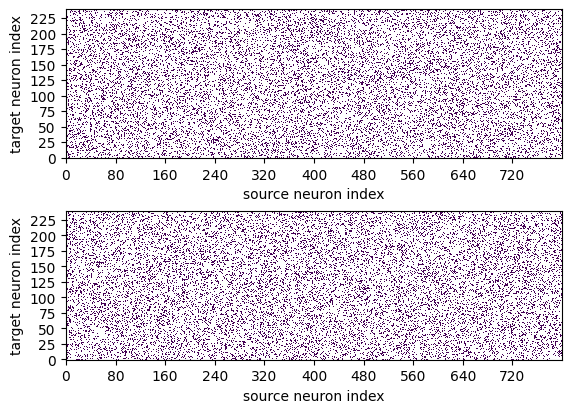

In [6]:
fig, axs = subplots(2,1) 
fig.add_axes(axs[0])
brian_plot(C_SE1_DE1)
fig.add_axes(axs[1])
brian_plot(C_SE2_DE2)
